In [2]:
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
%matplotlib notebook

# Noise model

Noise model for the current stabilizer

All values are referred to the coil current (RTC)

In [1]:
# simulation parameters
I_coil = 60  # coil current (A)
field = 147e-4  # Magnetic field (Tesla)
loop_bw = 3e3  # feedback loop noise bandwidth (Hz)

In [3]:
# Sensor option I: LEM IT 400-S Sensor
# data sheet: https://www.lem.com/sites/default/files/products_datasheets/it_400-s_ultrastab.pdf
# NB a newer model is now available: https://www.lem.com/sites/default/files/products_datasheets/in_1000-s.pdf

n_turns = 6  # number of turns of wire around the sensor
sensor_Ifs = 400  # sensor full-scale current (A)
G_sensor = 1/2000 * n_turns  # A/A
R_sense = 10  # transimpedance resistor in analog front-end (Ohm)

assert I_coil * n_turns < sensor_Ifs

# Broad-band noise (> 10Hz):
# - We measured the sensor noise floor to be <~1ppb/rtHz (RMS of full-scale)
#   this measurement was limited by the noise floor of our analog front end
# - The sensor data sheet specifies 8ppm RMS MAX integrated over 50kHz
#   eqivalent to 35ppb/rtHz
# - so the specification appears to be rather cautious
# - The newer IN-1000-S model specifies both typical and max noise,
#   with a factor of three difference between the two
in_sensor = 1e-9*(sensor_Ifs/n_turns) # sensor current noise (A RTC)

# sensor low frequency noise:
# - 0 to 10Hz integrated noise (0.05 ppm normalized to full-scale coil current)
#   taken from datasheet, probably quite pessimistic. 
# - for comparison with opamp/reference low freq noise, convert to pk-pk value RTC
#   (assume pk-pk = 6.6 * rms)
In_sensor = 6.6 * 0.05e-6*(sensor_Ifs/n_turns)/I_coil

print("power dissipated in sense resistor: {:.2f}W".format((I_coil*G_sensor)**2*R_sense))

power dissipated in sense resistor: 0.32W


In [20]:
# Sensor option II: resistor
G_sensor = 1
R_sense = 1/2000*6*10  # chosen to give same output voltage as the flux-gate
in_sensor = 0  # no board-band noise on top of the sense resistor Johnson noise
In_sensor = 0  # no low-frequency noise

print("power dissipated in {:.1f} mOhm sense resistor: {:.1f}W".format(R_sense*1e3, I_coil**2*R_sense))

power dissipated in 30.0 mOhm sense resistor: 108.0W


In [4]:
def johnson(res, temp=300):
    """ Johnson noise voltage caluclator
    :param res: resistance (Ohm)
    :param temp: temperature (K)
    :return: RMS noise voltage density (V/rtHz)
    """
    return np.sqrt(4*constants.k*res*temp) 

## Broadband noise

In [5]:
def print_white_noise(name, i_n):
    """:param i_n: noise density (A/rtHz)"""
    print("{}: {:.2f} ppb/rtHz ({:.3f} nT/rtHz), {:.3f} ppm RMS ({:.2f} nT RMS)".format(
        name,
        (i_n/I_coil)*1e9,
        (i_n/I_coil)*field*1e9,
        (i_n/I_coil)*np.sqrt(loop_bw)*1e6,
        (i_n/I_coil)*np.sqrt(loop_bw)*field*1e9))

In [6]:
# transimpedance stage
G_sense = G_sensor*R_sense  # V/A RTC

vn_sense = johnson(R_sense)
in_sense = vn_sense/G_sense  # A/rtHz RTC

print_white_noise("sense resistor", in_sense)

sense resistor: 0.23 ppb/rtHz (0.003 nT/rtHz), 0.012 ppm RMS (0.18 nT RMS)


In [7]:
# InAmp
# NB stage bandwidth is large compared with loop BW so assume white noise

opamp_vn = 1.8e-9  # ADA4004 voltage noise density (V/rtHz)
opamp_in = 1.2e-12  # ADA4004 current noise density (A/rtHz)

R_in = 16  # RFI filter resistors
R_inamp = 1e3  # InAmp resistors

noise_sources = [
    johnson(R_in)*np.sqrt(2),
    johnson(R_inamp)*np.sqrt(4),
    opamp_vn*np.sqrt(1**2 + 1**2 + 2**2),  # noise gain of final OpAmp is 2
    opamp_in*R_inamp*np.sqrt(2)
]

vn_inamp = np.sqrt(sum([noise**2 for noise in noise_sources]))
in_inamp = vn_inamp/G_sense

print_white_noise("InAmp resistors", noise_sources[1]/G_sense)
print_white_noise("InAmp OpAmp vn", noise_sources[2]/G_sense)
print_white_noise("InAmp OpAmp in", noise_sources[3]/G_sense)
print_white_noise("InAmp total", in_inamp)

InAmp resistors: 4.52 ppb/rtHz (0.066 nT/rtHz), 0.248 ppm RMS (3.64 nT RMS)
InAmp OpAmp vn: 2.45 ppb/rtHz (0.036 nT/rtHz), 0.134 ppm RMS (1.97 nT RMS)
InAmp OpAmp in: 0.94 ppb/rtHz (0.014 nT/rtHz), 0.052 ppm RMS (0.76 nT RMS)
InAmp total: 5.24 ppb/rtHz (0.077 nT/rtHz), 0.287 ppm RMS (4.22 nT RMS)


In [8]:
# error subtractor
R_fb = 100e3
R_g = 1e3
G_subtractor = 1 + R_fb/R_g

# all numbers referred to subtractor input
vn_r_g = johnson(R_g)*(R_fb/R_g)/G_subtractor
vn_r_fb = johnson(R_fb)/G_subtractor
vn_res = np.sqrt(vn_r_g**2+vn_r_fb**2)

vn_opamp_in = opamp_in*R_fb/G_subtractor
vn_opamp = np.sqrt(opamp_vn**2 + vn_opamp_in**2)

vn_ref = opamp_vn*(R_fb/R_g)/G_subtractor  # only OpAmp vn as all else filtered!

vn_sub = np.sqrt(vn_res**2 + vn_opamp**2 + vn_ref**2)

in_sub = vn_sub/G_sense

print_white_noise("Subtractor resistors", vn_res/G_sense)
print_white_noise("Subtractor OpAmp vn", opamp_vn/G_sense)
print_white_noise("Subtractor OpAmp in", vn_opamp_in/G_sense)
print_white_noise("Subtractor reference", vn_ref/G_sense)
print_white_noise("Subtractor total", in_sub)

Subtractor resistors: 2.25 ppb/rtHz (0.033 nT/rtHz), 0.123 ppm RMS (1.81 nT RMS)
Subtractor OpAmp vn: 1.00 ppb/rtHz (0.015 nT/rtHz), 0.055 ppm RMS (0.81 nT RMS)
Subtractor OpAmp in: 0.66 ppb/rtHz (0.010 nT/rtHz), 0.036 ppm RMS (0.53 nT RMS)
Subtractor reference: 0.99 ppb/rtHz (0.015 nT/rtHz), 0.054 ppm RMS (0.80 nT RMS)
Subtractor total: 2.73 ppb/rtHz (0.040 nT/rtHz), 0.150 ppm RMS (2.20 nT RMS)


<IPython.core.display.Javascript object>


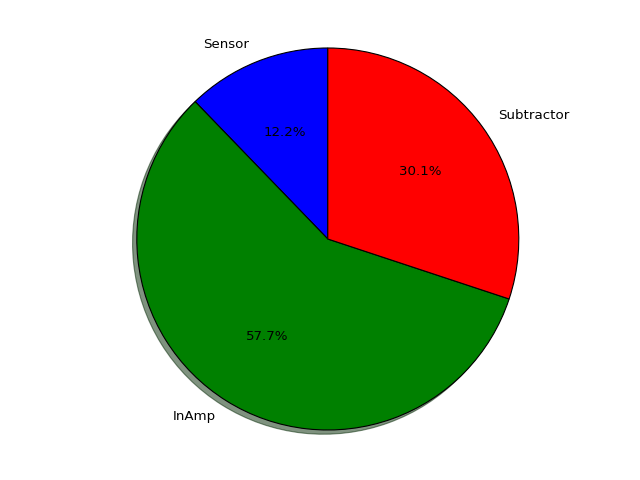

Total: 6.02 ppb/rtHz (0.088 nT/rtHz), 0.330 ppm RMS (4.85 nT RMS)


In [9]:
in_t = np.sqrt(in_sub**2 + in_inamp**2 + in_sensor**2)

labels = 'Sensor', 'InAmp', 'Subtractor'
sizes = np.array([in_sensor, in_inamp, in_sub])
sizes /= sum(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print_white_noise("Total", in_t)

- The AFE noise could be reduce by just over a factor of 2 by
  - using OpAmps with 0.9nV/rtHz voltage noise (about as low as one can get)
  - reducing the InAmp and subtractor resistors to 100Ohm
- We don't bother to do that because:
  - It's likely that the decrease in noise would be less than expected since the current transducer would start to dominate
  - the lower noise OpAmps draw a lot more quiescent current
  - For the OpAmps to drive the 2V sensor voltage into 100Ohm they would need to source/sink 40mA. That's more than most OpAmps can supply and, even if they could, the power dissipation could prove problematic (e.g. thermal issues degrading long-term stability). Assuming we don't add extra lower-voltage (e.g. $\pm$5V) supply rails for these OpAmps, that would be 480mW per amplifer. For a standard SOIC package $\theta_{\mathrm{JA}} \approx 120\mathrm{C}/\mathrm{W}$ so the temperature rise would be about 60C. For a 30C ambient temperature, that would put the OpAmps outside the 85C range that most OpAmps are specified to operate up to. With lower voltage supply rails, this would be more manageable, but would still rule out using quad OpAmps!
  - NB since we use a resistor ladder in the InAmp we only have a few options for the values of the resistors we can use
  - It's not clear that there is much point making the broad-band noise lower without also reducing the low-frequency noise. That could be done, for example, by using multiple references in parallel. But, the cost/complexity to performance ratio does not seem high enough to bother.
  

## Low-frequency noise

Dominated by the DAC

In [10]:
def print_low_freq_noise(name, I_n):
    """:param I_n: peak-peak current noise as a fraction of the full-scale coil current"""
    print("{}: {:.2f} ppm pk-pk ({:.3f} nT pk-pk)".format(
        name,
        I_n*1e6,
        I_n*field*1e9))

In [11]:
# sensor noise
print_low_freq_noise("sensor", In_sensor)

sensor: 0.37 ppm pk-pk (5.390 nT pk-pk)


In [12]:
# reference LTC6655 (2.048V, grade B)
# NB there is a newer -LN part number with lower noise
# the reference is filtered with a pole at ~16Hz, so we don't need to worry about the integrated white noise

V_ref = 2.048  # reference voltage reaching DACs

i_dac_fs = V_ref/G_sense  # equivalent full-scale coil current
G_dac = (I_coil/i_dac_fs)  # conversion between DAC full-scale value and the coil current

vn_ref = 0.25e-6  # 0..10Hz integrated noise (pk-pk as a fraction of full-scale)
in_ref = vn_ref*G_dac  # pk-pk noise as a fraction of coil current after scaling by dac

print_low_freq_noise("reference", in_ref)

reference: 0.22 ppm pk-pk (3.230 nT pk-pk)


In [13]:
# DAC (AD5541A)
# NB there is DAC AD5541 with lower low-frequency noise but otherwise comparable properties
# ignore DAC white noise density as small compared with the reference

vn_dac = 1.25e-6  # 0..10Hz pk-pk DAC noise (V)
# low-pass filtering with 2.2Hz pole will reduce noise slightly

in_dac = (vn_dac/V_ref)*(i_dac_fs/I_coil)  # pk-pk as a fraction of the coil current

print_low_freq_noise("DAC", in_dac)

DAC: 0.69 ppm pk-pk (10.208 nT pk-pk)


In [14]:
# OpAmps

# ADA4004-4 voltage noise is 0.15uV pk-pk 0..10Hz
vn_opamp = 0.15e-6  # 0..10Hz pk-pk OpAmp noise (V)
in_opamp = (vn_opamp/G_sense)/I_coil  # pk-pk as a fraction of the coil current

print_low_freq_noise("OpAmp voltage noise", in_opamp)
# NB this is the noise for each OpAmp, so the total contribution will be several times this...

# ADA4004-4 low-frequency current noise is not well specified
# ballpark as follows:
# - current noise converted to voltage by resistors, which are all ~1k
# - typical bias current is 40nA, so gives offsets around 40uV
# - assume 1% stability for this (very pessimistic in a well temp controlled environment)
# - gives around 0.4uV fluctuations, which are still below ref noise etc
# - so let's ignore this


OpAmp voltage noise: 0.08 ppm pk-pk (1.225 nT pk-pk)


<IPython.core.display.Javascript object>


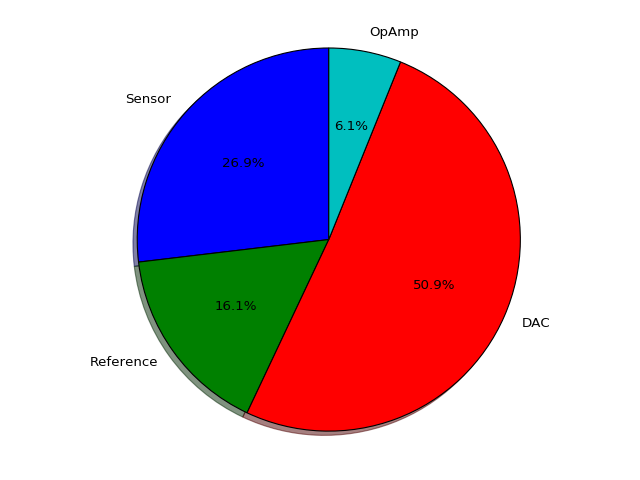

Total: 0.82 ppm pk-pk (12.050 nT pk-pk)


In [15]:
in_t = np.sqrt(In_sensor**2 + in_ref**2 + in_dac**2 + in_opamp**2)

labels = 'Sensor', 'Reference', 'DAC', 'OpAmp'
sizes = np.array([In_sensor, in_ref, in_dac, in_opamp])
sizes /= sum(sizes)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print_low_freq_noise("Total", in_t)

# Long-term/Thermal stability

## DAC
- offset (zero-code) temp co is: +-0.05 ppm/K
- gain temp co is +-0.1 ppm/K
- negligible

## OpAmps
- Offset voltage: 1uV/C typical, assuming 2V as the sensor volage, this corresponds to approx 0.5ppm/K
- offset/bias current: 40nA typical, corresponding to 40uV total offsets.
  Assuming this is stable to even 1%/K, it's negligible

## sense resistor
- ± 0.05 ppm/K
- negligible

## InAmp resistors:
- LT5400-A-4 0.2ppm/K
- negligible

## fluxgate sensor:
- 1 ppm/K (MAX, probably pessimistic)

## reference:
- LTC6655-2.048V (B-grade)
- 60 ppm/rt(k Hour)
- 1 ppm/K typical (2ppm/K max)
- There exist also references in hermetically sealed LS8 packages with only 20 ppm/rt(k Hour) drift. However, they are not available for 2.048V output level and require additional divider resistors to provide 2V to the DACs

## subtractor resistors:
 - no temp co specified. Assume these are 5ppm/K
 - $V_0 = V_{\mathrm{sensor}} + \frac{R_{\mathrm{f}}}{R_{\mathrm{g}}}\left(V_{\mathrm{ref}}-V_{\mathrm{sensor}}\right) $ 
 - for closed-loop operation, $V_0=0$ so $V_{\mathrm{sensor}}\left(1- \frac{R_{\mathrm{g}}}{R_{\mathrm{f}}}\right)= V_{\mathrm{ref}}$
 - so, all temperature coefficients are suppressed by a factor of order $\frac{R_{\mathrm{f}}}{R_{\mathrm{g}}} = 100 $
 - so, we do want something better than standard 100ppm/K, but don't need to be ultra-low temp co. (25ppm/K or lower is fine)
 - essentially, this is non-critical since the gain for the sensor and reference is almost identical, so drifts in the resistor values common-mode out
 

<IPython.core.display.Javascript object>


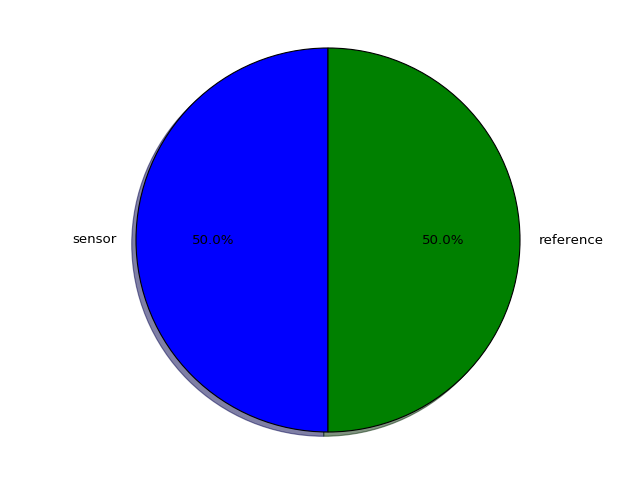

Total temp co: 1.41 ppm/K (20.79 nT/K)


In [16]:
# rough estimate of temp co based on above numbers...
labels = 'sensor', 'reference'
sizes = np.array([1., 1.])
sizes /= sum(sizes)
explode = (0.0, 0.)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

temp_co = np.sqrt(1**2 + 1**2)*1e-6
print('Total temp co: {:.2f} ppm/K ({:.2f} nT/K)'.format(temp_co*1e6, temp_co*field*1e9))